In [10]:
import os
from skimage import io, color
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.io import read_image
from torchvision import transforms
import torch_directml
from tqdm import tqdm
import lightning as L
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint, RichProgressBar

%matplotlib inline

device = torch_directml.device()
print(f"Using device: {device}")

Using device: privateuseone:0


In [11]:
class ImageNetDataset(Dataset):
    def __init__(self, root_dir, train=True, n_samples=1281167, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.n_samples = n_samples
        self.train = train
        self.annotations_file = pd.read_csv(os.path.join(root_dir, "train.csv" if train else "test.csv"), header=None).sample(n=n_samples, ignore_index=True)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        """Loads an image from a file, converts to LAB color space, and returns (L, [A; B])."""
        image_path = os.path.join(self.root_dir, self.annotations_file.iloc[idx, 0])

        rgb_img = io.imread(image_path)
        lab_img = color.rgb2lab(rgb_img)
        
        # split into L, A, B channels
        l, ab = lab_img[:, :, 0], lab_img[:, :, 1:]

        if self.transform:
            l = self.transform(l)
        if self.target_transform:
            ab = self.target_transform(ab)

        return l.float(), ab.float()

In [12]:
class ImageNetDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = "data/", batch_size: int = 128, n_train: int = 1281167, n_test: int = 50000):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.n_train = n_train
        self.n_test = n_test
    
    def setup(self, stage: str):
        train_set_size = int(self.n_train * 0.8)
        val_set_size = self.n_train - train_set_size

        self.imagenet_test =  ImageNetDataset(root_dir=self.data_dir, train=False, n_samples=self.n_test, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())
        imagenet_full = ImageNetDataset(root_dir=self.data_dir, train=True, n_samples=self.n_train, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())
        self.imagenet_train, self.imagenet_val = random_split(imagenet_full, [train_set_size, val_set_size])
    
    def train_dataloader(self):
        return DataLoader(self.imagenet_train, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.imagenet_val, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self.imagenet_test, batch_size=self.batch_size, shuffle=False)
    
    def predict_dataloader(self):
        return DataLoader(self.imagenet_test, batch_size=self.batch_size, shuffle=False)

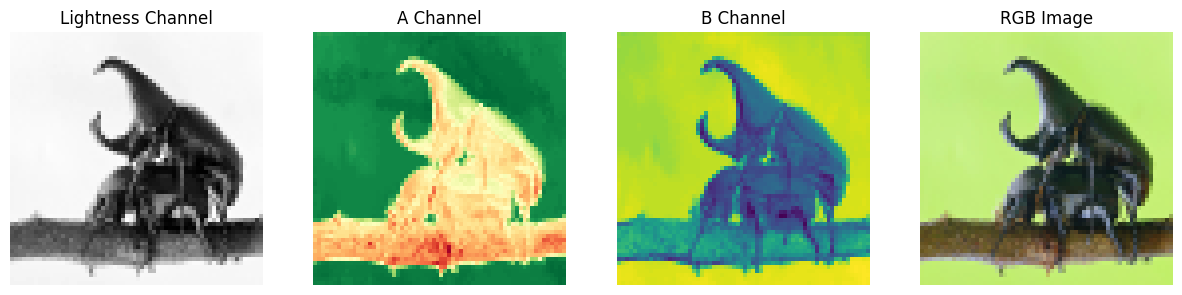

In [13]:
dm = ImageNetDataModule()
dm.setup("fit")
l, ab = next(iter(dm.train_dataloader()))

fig, ax = plt.subplots(1, 4, figsize=(15, 7))
ax[0].imshow(l[0].squeeze(), cmap="gray")
ax[0].set_title("Lightness Channel")
ax[0].set_axis_off()

ax[1].imshow(ab[0,0], cmap="RdYlGn_r")
ax[1].set_title("A Channel")
ax[1].set_axis_off()

ax[2].imshow(ab[0, 1])
ax[2].set_title("B Channel")
ax[2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab = np.concatenate((l[0].numpy(), ab[0].numpy()), axis=0).transpose(1, 2, 0)
rgb = color.lab2rgb(lab)

ax[3].imshow(rgb, interpolation=None)
ax[3].set_title("RGB Image")
ax[3].set_axis_off()

In [14]:
class ImageColorizerModel(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        self.conv8 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0),
        )

        self.softmax = nn.Softmax2d()
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.upsample = nn.Upsample(scale_factor=8, mode="bilinear")
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.softmax(x)
        x = self.model_out(x)
        x = self.upsample(x)
        return x
    
    def _get_loss(self, batch):
        l, ab = batch
        ab_hat = self(l)
        loss = F.mse_loss(ab_hat, ab)
        return loss
    
    def training_step(self, batch, batch_idx):
        l, ab = batch
        loss = self._get_loss(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        l, ab = batch
        loss = self._get_loss(batch)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        l, ab = batch
        loss = self._get_loss(batch)
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [15]:
from torchinfo import summary
model = ImageColorizerModel()
summary(model, input_size=(128, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
ImageColorizerModel                      [128, 2, 64, 64]          --
├─Sequential: 1-1                        [128, 64, 32, 32]         --
│    └─Conv2d: 2-1                       [128, 64, 64, 64]         640
│    └─ReLU: 2-2                         [128, 64, 64, 64]         --
│    └─Conv2d: 2-3                       [128, 64, 32, 32]         36,928
│    └─ReLU: 2-4                         [128, 64, 32, 32]         --
│    └─BatchNorm2d: 2-5                  [128, 64, 32, 32]         128
├─Sequential: 1-2                        [128, 128, 16, 16]        --
│    └─Conv2d: 2-6                       [128, 128, 32, 32]        73,856
│    └─ReLU: 2-7                         [128, 128, 32, 32]        --
│    └─Conv2d: 2-8                       [128, 128, 16, 16]        147,584
│    └─ReLU: 2-9                         [128, 128, 16, 16]        --
│    └─BatchNorm2d: 2-10                 [128, 128, 16, 16]        256

In [17]:
batch_size = 32
n_train = 1000
n_test = 100
n_epochs = 32

dm = ImageNetDataModule(
    batch_size=batch_size,
    n_train=n_train,
    n_test=n_test,
)
model = ImageColorizerModel()

trainer = L.Trainer(max_epochs=n_epochs)
trainer.fit(model, dm)

MisconfigurationException: No supported gpu backend found!

In [ ]:
trainer.test(model=model, datamodule=dm)

/home/pavva/Projects/image-colorizer/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │     344.0180969238281     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 344.0180969238281}]

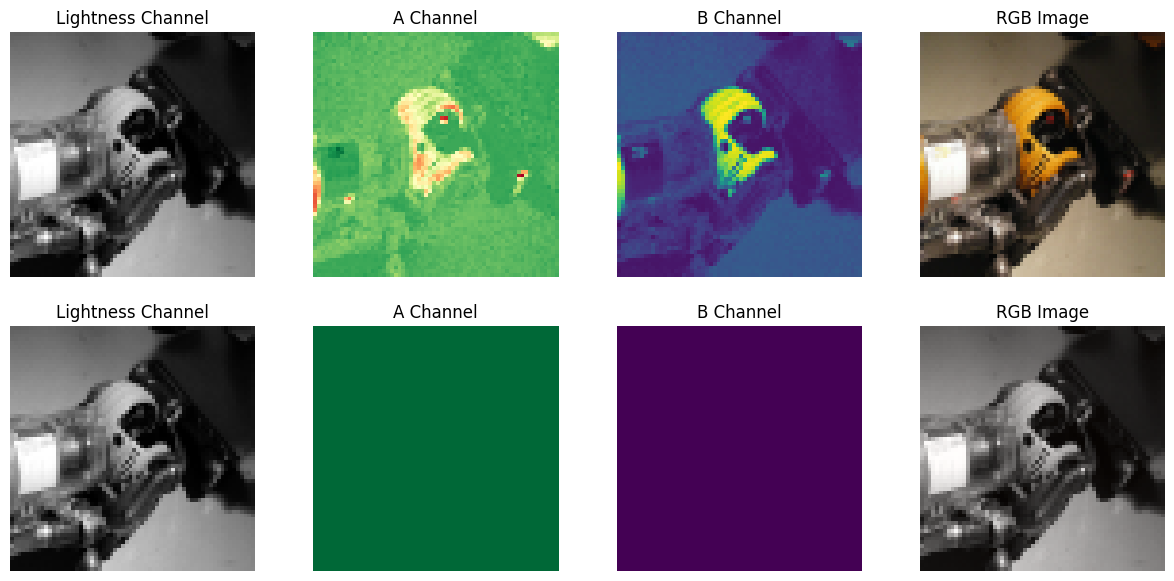

In [ ]:
l, ab = next(iter(dm.train_dataloader()))
ab_hat = model.forward(l)

fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0, 0].imshow(l[0].squeeze(), cmap="gray")
ax[0, 0].set_title("Lightness Channel")
ax[0, 0].set_axis_off()

ax[0, 1].imshow(ab[0,0], cmap="RdYlGn_r")
ax[0, 1].set_title("A Channel")
ax[0, 1].set_axis_off()

ax[0, 2].imshow(ab[0, 1])
ax[0, 2].set_title("B Channel")
ax[0, 2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab = np.concatenate((l[0].numpy(), ab[0].numpy()), axis=0).transpose(1, 2, 0)
rgb = color.lab2rgb(lab)

ax[0, 3].imshow(rgb, interpolation=None)
ax[0, 3].set_title("RGB Image")
ax[0, 3].set_axis_off()

ax[1, 0].imshow(l[0].squeeze(), cmap="gray")
ax[1, 0].set_title("Lightness Channel")
ax[1, 0].set_axis_off()

ax[1, 1].imshow(ab_hat[0,0].detach().numpy(), cmap="RdYlGn_r")
ax[1, 1].set_title("A Channel")
ax[1, 1].set_axis_off()

ax[1, 2].imshow(ab_hat[0, 1].detach().numpy())
ax[1, 2].set_title("B Channel")
ax[1, 2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab_hat = np.concatenate((l[0].numpy(), ab_hat[0].detach().numpy()), axis=0).transpose(1, 2, 0)
rgb_hat = color.lab2rgb(lab_hat)

ax[1, 3].imshow(rgb_hat, interpolation=None)
ax[1, 3].set_title("RGB Image")
ax[1, 3].set_axis_off()